More resources:

- [An example](https://www.alexbod.com/hopfield-neural-network/) with rotation and C code
- [Nice little letters](https://github.com/ccd97/hello_nn/blob/master/Hopfield-Network/np_hnn_reconstruction.ipynb) and denoising that works!
- [My matlab code](https://gist.github.com/mikolasan/5f40cbea6db57bedc96c8bb6762c9ab0) which is absolutely unreadable (brrr)

In [1]:
import random

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
# Define a function to load the arrays from the file
def load_arrays_from_file(filename):
    with open(filename, 'r') as file:
        data = file.read().strip().split('\n')  # Read file and split by newline
    
    arrays = []
    for line in data:
        # Convert the string of numbers into a numpy array
        array = np.array([int(x) for x in line.split()])
        arrays.append(array)
    
    return arrays

# Load the arrays
arrays = load_arrays_from_file('hopfield-clean.seq')

In [3]:
len(arrays)

360

In [4]:
# Define the array
# data = np.array([
#     -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, -1, 
#     -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1,
#     1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 
#     -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1,
#     1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 
#     -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1,
#     1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 
#     -1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1
# ])

In [4]:
def print_flat_array_as_num(arr):
    # Reshape to 8x12
    sq = arr.reshape(12, 8)

    # Create a colormap for -1 as white and 1 as black
    cmap = plt.cm.gray
    norm = plt.Normalize(vmin=-1, vmax=1)

    # Plot the figure
    plt.figure(figsize=(6, 4))
    plt.imshow(sq, cmap=plt.cm.gray_r, norm=norm)
    plt.xticks([])  # No ticks on x axis
    plt.yticks([])  # No ticks on y axis
    plt.grid(False)
    plt.show()

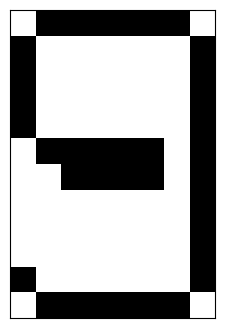

In [6]:
a1 = random.choice(arrays)
print_flat_array_as_num(a1)

We store patterns using Hebbian learning:

$
W_{ij} = \sum_{\mu} \xi_i^\mu \xi_j^\mu
$

Where $ \xi^\mu $ is the pattern, and $ W_{ij} $ is the connection weight between neurons $ i $ and $ j $. The weights are normalized by the number of patterns to avoid growing too large. $ W $ is symmetrical, $ W_{ij} = W_{ji} $, and the diagonal (self-connections) is set to zero (why???).

In [5]:
# return weights matrix
def naive_train(data):
    M, N = data.shape
    print("data shape", M, N)
    
    W = np.zeros((M, M))
    rho = np.sum([np.sum(t) for t in data]) / (N * M)
    for k in range(N):
        t = data[:, k] - rho
        W += np.outer(t, t)

    W /= N
    
    # Zeroing the diagonal
    np.fill_diagonal(W, 0)
    return W

The forward pass updates the state iteratively, recalculating the state of each neuron based on the sum of inputs from other neurons. This iterative process runs for a specified number of steps or until convergence.

In [6]:
# This function approximates the behavior of the MATLAB satlins function 
# (saturating linear transfer) using np.clip().
def satlins(x):
    return np.clip(x, 0, 1)

def predict(data, W):
    CY = []

    M, N = data.shape
    # Iterating over each column of t
    for k in range(N):
        u = data[:, k]
        while np.linalg.norm(satlins(W @ u) - u) > 0:
            u = satlins(W @ u)
        CY.append(u)

    CY = np.array(CY).T  # Convert list of arrays to 2D array
    return CY

In [7]:
def plot_weights(W):
    plt.figure(figsize=(6, 5))
    w_mat = plt.imshow(W, cmap=cm.coolwarm)
    plt.colorbar(w_mat)
    plt.title("Network Weights")
    plt.tight_layout()
    plt.show()

In [39]:
t = np.array(arrays).T
S, Q = t.shape
W = naive_train(t)

p = predict(t, W)

data shape 96 360


In [13]:
M = 96
W = np.zeros((M, M))

In [14]:
def train_step(W, pattern):
    W += np.outer(pattern, pattern)
    np.fill_diagonal(W, 0)
    return W

In [17]:
def predict_one(W, pattern):
    u = np.array(pattern) # copy
    while np.linalg.norm(satlins(W @ u) - u) > 0:
        u = satlins(W @ u)
    return u

In [54]:
a = arrays[20]
W = train_step(W, a)
p = predict_one(W, a)

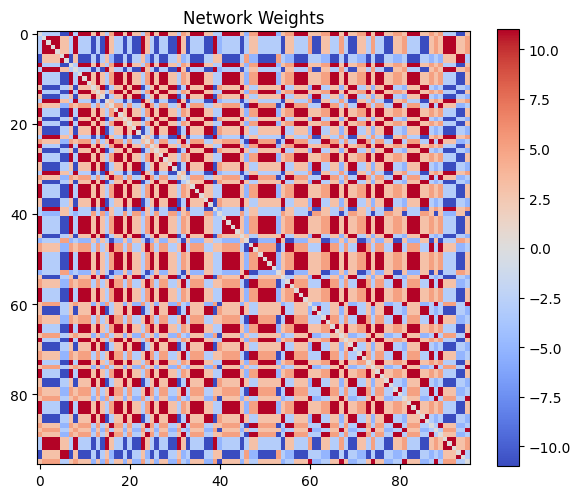

In [55]:
plot_weights(W)


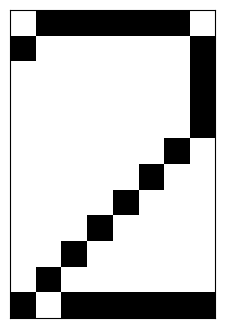

In [36]:
print_flat_array_as_num(arrays[20])

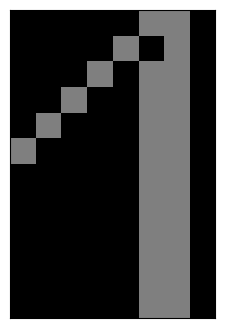

In [63]:
p = predict_one(W, arrays[50])
print_flat_array_as_num(p)

In [12]:
space = 2
n_copies = 30
n_classes = 12
digit_height = 12
digit_width = 8
alld = np.zeros(
    (n_classes * (digit_height + space) - space, 
    n_copies * (digit_width + space) - space))
print(alld.shape)

def print_full_grid(arr):
    M, N = arr.shape
    for p in range(N):
        otv = np.zeros((digit_height, digit_width))
        ot = arr[:, p]
        for n in range(M):
            otv[n // digit_width, n % digit_width] = ot[n]

        x = (p % n_copies) * space
        y = (p // n_copies) * space
        a = slice(
            (p // n_copies) * digit_height + y, 
            (p // n_copies + 1) * digit_height + y)
        b = slice(
            x + (p % n_copies) * digit_width, 
            x + (p % n_copies + 1) * digit_width)
        alld[a, b] = otv

    # Plotting the results
    fig, ax = plt.subplots(figsize=(15, 15))
    # cmap = plt.cm.get_cmap('gray')
    ax.imshow(alld, cmap=plt.cm.gray_r)
    ax.grid(True)

    plt.show()

(166, 298)


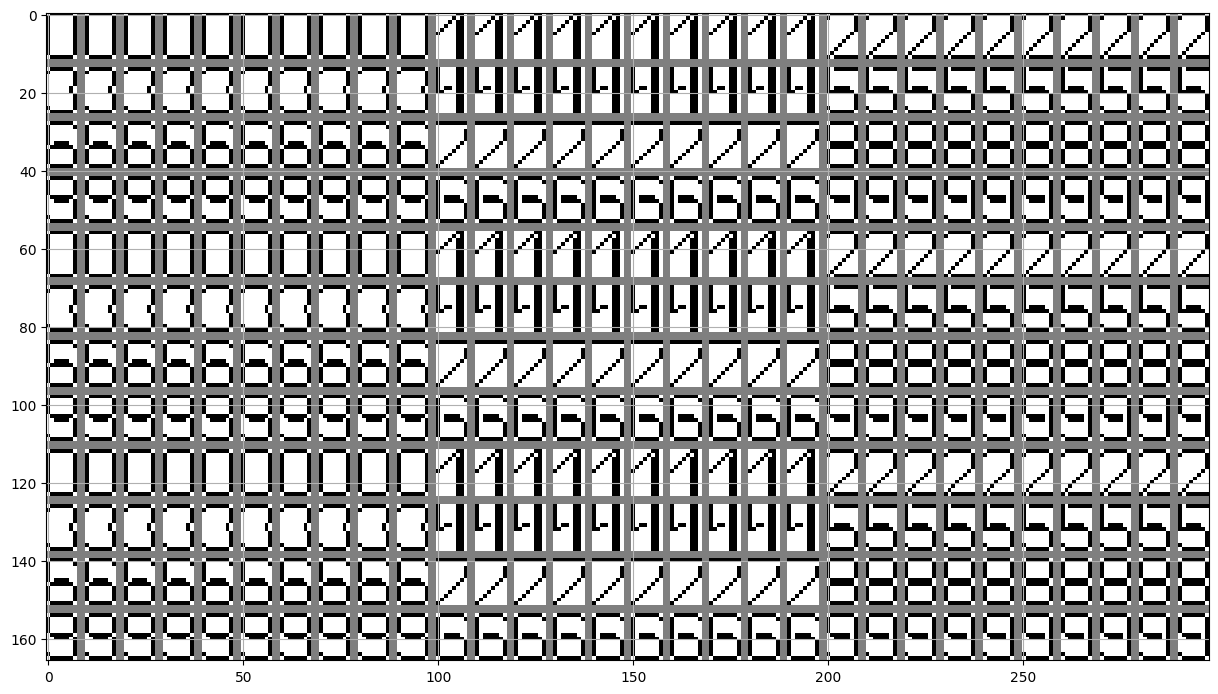

In [41]:
print_full_grid(t)

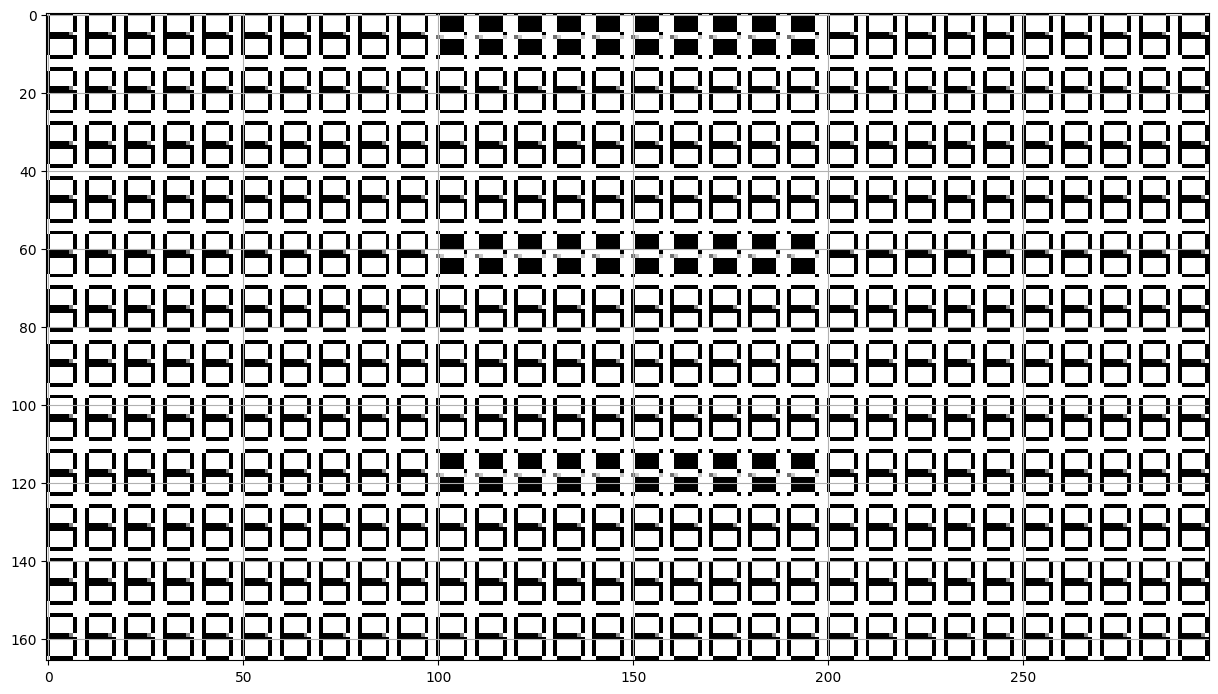

In [42]:
print_full_grid(p)

In [28]:
# https://github.com/takyamamoto/Hopfield-Network/tree/master

import matplotlib.cm as cm

class HopfieldNetwork(object):      
    def train_weights(self, train_data):
        print("Start to train weights...")
        num_data =  len(train_data)
        self.num_neuron = train_data[0].shape[0]
        
        # initialize weights
        W = np.zeros((self.num_neuron, self.num_neuron))
        rho = np.sum([np.sum(t) for t in train_data]) / (num_data*self.num_neuron)
        print("rho", rho)
        
        # Hebb rule
        for i in range(num_data):
            t = train_data[i] - rho
            W += np.outer(t, t)
        
        # Make diagonal element of W into 0
        diagW = np.diag(np.diag(W))
        W = W - diagW
        W /= num_data
        
        self.W = W 
    
    def predict(self, data, num_iter=20, threshold=0, asyn=False):
        print("Start to predict...")
        self.num_iter = num_iter
        self.threshold = threshold
        self.asyn = asyn
        
        # Copy to avoid call by reference 
        copied_data = np.copy(data)
        
        # Define predict list
        predicted = []
        for i in range(len(data)):
            predicted.append(self._run(copied_data[i]))
        return predicted
    
    def _run(self, init_s):
        if self.asyn==False:
            """
            Synchronous update
            """
            # Compute initial state energy
            s = init_s

            e = self.energy(s)
            
            # Iteration
            for i in range(self.num_iter):
                # Update s
                s = np.sign(self.W @ s - self.threshold)
                # Compute new state energy
                e_new = self.energy(s)
                
                # s is converged
                if e == e_new:
                    return s
                # Update energy
                e = e_new
            return s
        else:
            """
            Asynchronous update
            """
            # Compute initial state energy
            s = init_s
            e = self.energy(s)
            
            # Iteration
            for i in range(self.num_iter):
                for j in range(100):
                    # Select random neuron
                    idx = np.random.randint(0, self.num_neuron) 
                    # Update s
                    s[idx] = np.sign(self.W[idx].T @ s - self.threshold)
                
                # Compute new state energy
                e_new = self.energy(s)
                
                # s is converged
                if e == e_new:
                    return s
                # Update energy
                e = e_new
            return s
    
    
    def energy(self, s):
        return -0.5 * s @ self.W @ s + np.sum(s * self.threshold)

    def plot_weights(self):
        plt.figure(figsize=(6, 5))
        w_mat = plt.imshow(self.W, cmap=cm.coolwarm)
        plt.colorbar(w_mat)
        plt.title("Network Weights")
        plt.tight_layout()
        plt.savefig("weights.png")
        plt.show()
        

In [29]:
model = HopfieldNetwork()
model.train_weights(arrays)

Start to train weights...
rho -0.34375


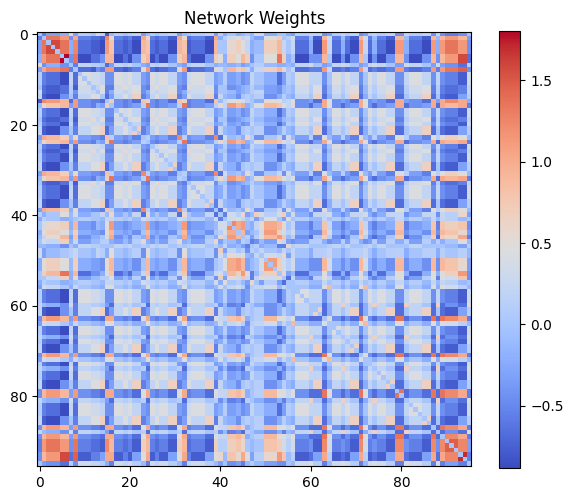

In [17]:
model.plot_weights()

In [18]:
pp = model.predict(arrays[0:50])

Start to predict...


In [19]:
ppp = np.array(pp).T

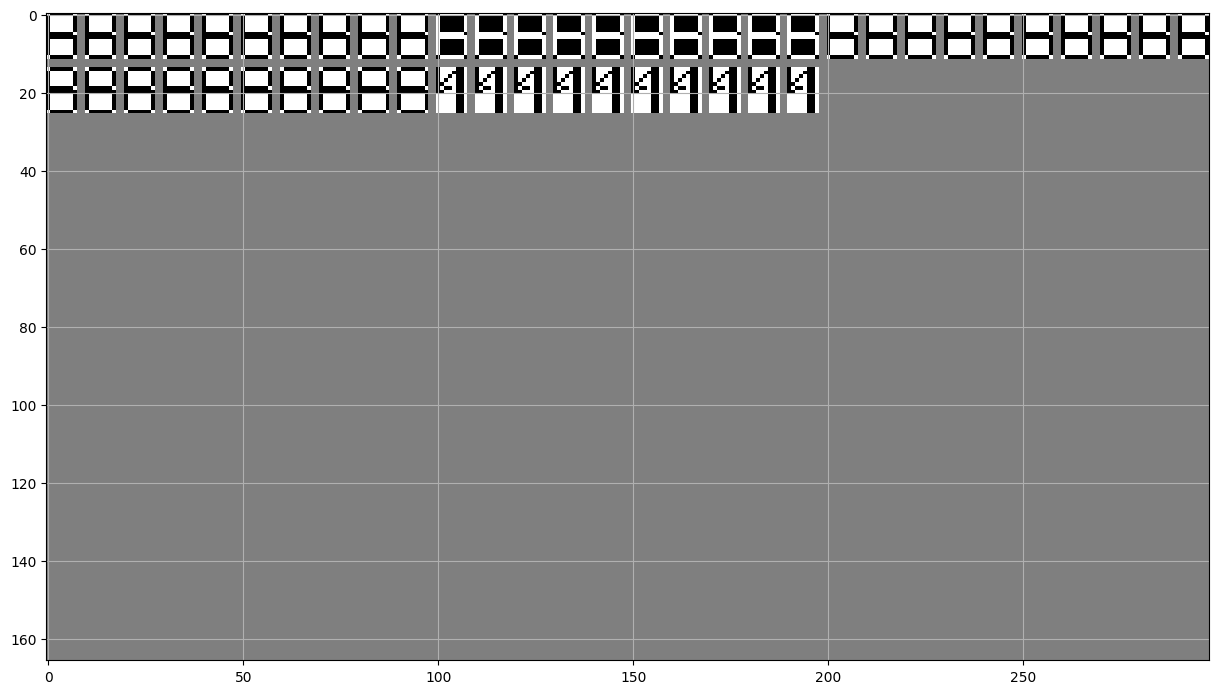

In [20]:
print_full_grid(ppp)

In [64]:
import torch
import torch.nn as nn

In [69]:
class HopfieldNetworkTorch(nn.Module):
    def __init__(self, num_neurons):
        super(HopfieldNetworkTorch, self).__init__()
        self.num_neurons = num_neurons
        self.weights = torch.zeros(num_neurons, num_neurons)

    def store_patterns(self, patterns):
        """
        Store patterns into the weight matrix using Hebbian learning.
        Patterns should be a tensor of shape (num_patterns, num_neurons).
        """
        num_patterns = patterns.size(0)
        for i in range(num_patterns):
            p = patterns[i].unsqueeze(1)  # Make it a column vector
            self.weights += torch.mm(p, p.T)  # Hebbian learning rule
        # Ensure weights on the diagonal are zero
        self.weights.fill_diagonal_(0)
        self.weights /= num_patterns  # Normalize by the number of patterns
    
    def store_pattern(self, pattern):
        p = pattern.unsqueeze(1)  # Make it a column vector
        self.weights += torch.mm(p, p.T)  # Hebbian learning rule
        # Ensure weights on the diagonal are zero
        self.weights.fill_diagonal_(0)

    def forward(self, input_state, max_steps=100):
        """
        Forward pass: iteratively update the states of the network.
        Returns early if a stable state is reached.
        """
        state = input_state.clone()
        prev_state = state.clone()

        for _ in range(max_steps):
            # Update all neurons at once for simplicity
            net_input = torch.matmul(self.weights, state)  # Weighted sum of inputs
            state = torch.tanh(net_input)  # Continuous activation (differentiable)
        
#             # For each neuron, update its state
#             for i in range(self.num_neurons):
#                 net_input = torch.dot(self.weights[i], state)  # Weighted sum of inputs
#                 state[i] = 1 if net_input >= 0 else -1  # Update rule (sign function)

            # Early stopping if state does not change
            if torch.equal(state, prev_state):
                break
            prev_state = state.clone()

        return state
      
    def plot_weights(self):
        plt.figure(figsize=(6, 5))
        w_mat = plt.imshow(self.weights, cmap=cm.coolwarm)
        plt.colorbar(w_mat)
        plt.title("Network Weights")
        plt.tight_layout()
        plt.show()

In [73]:
torch.Tensor(arrays)[0].shape

torch.Size([96])

In [74]:
n_neurons = M
torch_hop = HopfieldNetworkTorch(n_neurons)
data = torch.Tensor(arrays)
torch_hop.store_patterns(data)

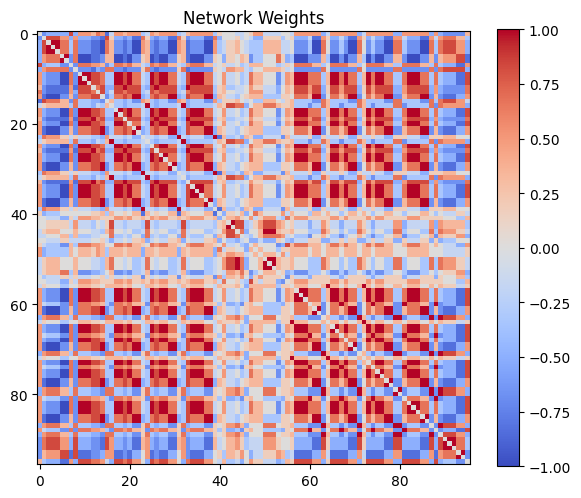

In [75]:
torch_hop.plot_weights()

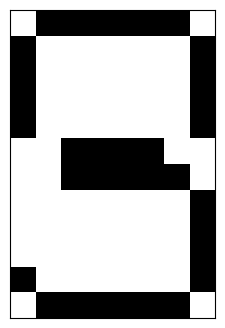

In [79]:
pred = torch_hop.forward(data[20]).numpy()
print_flat_array_as_num(pred)

## Exercise

Backpropagation through a Hopfield network is not straightforward because Hopfield networks are generally considered to be energy-based models

In [ ]:
# Assuming `output` is the Hopfield model's output and `target` is the ground truth
criterion = nn.MSELoss()  # Mean Squared Error loss for continuous output
optimizer = torch.optim.SGD(hopfield_model.parameters(), lr=0.01)

# Forward pass
output = hopfield_model(input_state)

# Compute loss
loss = criterion(output, target)

# Backward pass
loss.backward()

# Optimizer step
optimizer.step()